# Contextualized token embeddings for semantic change detection

In [1]:
import matplotlib.pylab as plot
import numpy as np
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine, cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd

# Loading the test set

For simplicity, we are using a version of SemEval'20 English test set *without POS tags*.

In [2]:
graded = pd.read_csv("targets/english/graded_nopos.txt", sep="\t", header=None,
                     names=['word', 'truth'])

In [3]:
graded

,word,truth
0,attack,0.143970
1,bag,0.100364
2,ball,0.409367
3,bit,0.306577
4,chairman,0.000000
5,circle,0.171087
6,contemplation,0.070839
7,donkey,0.160104
8,edge,0.260966
9,face,0.137791


In [4]:
targets = graded.word

In [5]:
f"Target lemmas: {len(targets)}."

'Target lemmas: 37.'

Again, corpus1 is XIX century English, corpus 2 is XX century English

# 1. Embedding part

We assume the token embeddings are already extracted using the language model of our choice (BERT, XLM-R, etc).
If you are curious, look at the `extract.py` script.
Embeddings are stored as Numpy matrices (compressed). They are about 200 MBytes each, so we publish them separately.

In [ ]:
!wget -c https://www.mn.uio.no/ifi/english/people/aca/andreku/token_embeddings_corpus1_xlmr.npz

In [ ]:
!wget -c https://www.mn.uio.no/ifi/english/people/aca/andreku/token_embeddings_corpus2_xlmr.npz

In [6]:
data_path1= "token_embeddings_corpus1_xlmr.npz"

In [7]:
array1 = np.load(data_path1)

In [8]:
f"Loaded an array of {len(array1)} entries from {data_path1}"

'Loaded an array of 37 entries from token_embeddings_corpus1_xlmr.npz'

In [9]:
data_path2 = "token_embeddings_corpus2_xlmr.npz"

In [10]:
array2 = np.load(data_path2)

In [11]:
f"Loaded an array of {len(array2)} entries from {data_path2}"

'Loaded an array of 37 entries from token_embeddings_corpus2_xlmr.npz'

# Visualizing token embeddings

In [12]:
word = "plane"

In [13]:
array = array2[word]
array.shape

(1492, 768)

In [14]:
embedding = PCA(n_components=2)
y = embedding.fit_transform(array)

In [15]:
xpositions = y[:, 0]
ypositions = y[:, 1]

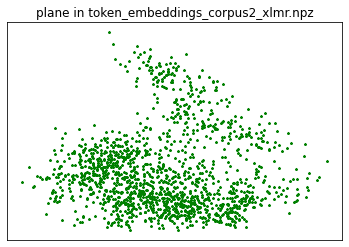

In [16]:
plot.clf()
plot.scatter(xpositions, ypositions, 5, marker='*', color='green')
plot.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plot.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plot.title(f"{word} in {data_path2}")
plot.show()

Every dot is a 768-dimensional token embeddings projected into 2 dimensions.
Can you show both time periods side by side?

We can show two time periods on one plot as well:

In [17]:
embeddings = {"bin1": array1[word], "bin2": array2[word]}

In [18]:
embeddings["bin2"].shape

(1492, 768)

In [19]:
x = np.concatenate([embeddings[el] for el in sorted(embeddings)], axis=0)

In [20]:
x.shape

(1932, 768)

We want to show usages from different time bins with different colors, thus, we need class labels

In [21]:
class_labels = []
for el in sorted(embeddings):
    class_labels += [el] * len(embeddings[el])

In [22]:
len(class_labels)

1932

We are projecting all embeddings into 2 dimensions with PCA or TSNE:

In [32]:
x = preprocessing.StandardScaler().fit_transform(x)
x_2d = PCA(n_components=2).fit_transform(x)

In [33]:
class_set = sorted([c for c in set(class_labels)])
colors = plot.cm.Dark2(np.linspace(1, 0, len(class_set)))

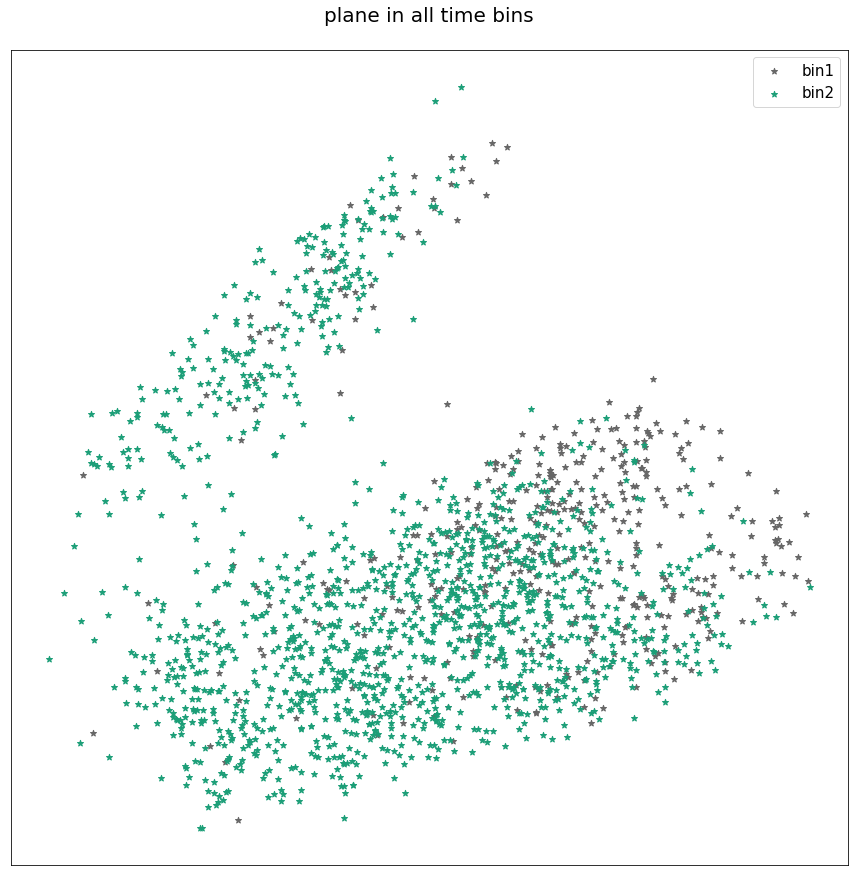

In [34]:
plot.clf
plot.figure(figsize=(15, 15))
plot.xticks([]), plot.yticks([])
plot.title(f"{word} in all time bins\n", fontsize=20)
for year in class_set:
    rows = [x == year for x in class_labels]
    matrix = x_2d[rows]
    plot.scatter(matrix[:, 0], matrix[:, 1], color=colors[class_set.index(year)], marker='*', s=40, label=year)
plot.legend(prop={'size': 15}, loc="best")
plot.show()

What we will need to be able to inspect the actual usages? How to annotate the dots with the identifiers pointing at real sentences?

Anyway, now we would like to use the token embeddings to quantitatively estimate the degree of semantic change. And here comes the...

# 2. Aggregating and assessment part

There are many usages and many token embeddings. We need to somehow *aggregate* them for each time period, before *assessing* the change.

The simplest is the PRT method (comparison of averaged *prototypical* embeddings):

## PRT

In [35]:
prt_predictions = []

In [36]:
for word in sorted(targets):
    frequency = np.sum([array1[word].shape[0], array2[word].shape[0]])
    vectors1 = array1[word]
    vectors2 = array2[word]
    vectors = []
    for m in [vectors1, vectors2]:
        # Aggregation:
        vector = np.average(m, axis=0)
        vectors.append(vector)
    vectors = [preprocessing.normalize(v.reshape(1, -1), norm='l2') for v in vectors]
    # Assessment:
    shift = 1 - np.dot(vectors[0].reshape(-1), vectors[1].reshape(-1))
    prt_predictions.append(shift)

In [37]:
graded["prt_predictions"] = prt_predictions

In [38]:
graded

,word,truth,prt_predictions
0,attack,0.143970,0.005644
1,bag,0.100364,0.009337
2,ball,0.409367,0.003656
3,bit,0.306577,0.047555
4,chairman,0.000000,0.005544
5,circle,0.171087,0.006366
6,contemplation,0.070839,0.003035
7,donkey,0.160104,0.005218
8,edge,0.260966,0.007862
9,face,0.137791,0.006821


Let's evaluate the predictions. How correlated they are with the ground truth (human judgments)?

In [44]:
correlation = spearmanr(graded.truth, graded.prt_predictions)
print(f"Spearman ranked correlation: {correlation[0]:0.4f}; p-value: {correlation[1]:0.4f}")

Spearman ranked correlation: 0.3198; p-value: 0.0537


## APD

Average Pairwise Distance (APD) is a more sophisticated aggreation method. It computes pairwise distances between *all* usages from two time bins and averages these distances.

In [60]:
def mean_pairwise_distance(usage_matrix1, usage_matrix2, metric="cosine"):
    """
    Computes the mean pairwise distance between two usage matrices.

    :param word_usages1: usage matrix 1
    :param word_usages2: usage matrix 2
    :param metric: a distance metric compatible with `scipy.spatial.distance.cdist`
    (e.g. 'cosine', 'euclidean')
    :return: the mean pairwise distance between two usage matrices
    """
    if usage_matrix1.shape[0] == 0 or usage_matrix2.shape[0] == 0:
        raise ValueError('Zero-dimensional usage matrix.')
    # cdist is the most computationally expensive operation here
    return np.mean(cdist(usage_matrix1, usage_matrix2, metric=metric))

Computational complexity naturally grows quadratically with the number of usages, so we will introduce sampling of max 5 000 random usages from each time bin.

In [54]:
max_samples = 5000

In [55]:
apd_predictions = []

In [56]:
for word in sorted(targets):
    frequency = np.sum([array1[word].shape[0], array2[word].shape[0]])
    print(f"Processing {word} with the total frequency {frequency}...")
    vectors1 = array1[word]
    vectors2 = array2[word]
    if vectors1.shape[0] > max_samples:
        prev = vectors1.shape[0]
        rand_indices = np.random.choice(prev, max_samples, replace=False)
        vectors1 = vectors1[rand_indices]
        print(f"Choosing {max_samples} random usages from {prev} for {word} in T0")
    if vectors2.shape[0] > max_samples:
        prev = vectors2.shape[0]
        rand_indices = np.random.choice(prev, max_samples, replace=False)
        vectors2 = vectors2[rand_indices]
        print(f"Choosing {max_samples} random usages from {prev} for {word} in T1")
    shift = mean_pairwise_distance(vectors1, vectors2, "cosine")
    apd_predictions.append(shift)

Processing attack with the total frequency 1969...
Processing bag with the total frequency 1500...
Processing ball with the total frequency 2167...
Processing bit with the total frequency 2804...
Processing chairman with the total frequency 677...
Processing circle with the total frequency 1532...
Processing contemplation with the total frequency 346...
Processing donkey with the total frequency 271...
Processing edge with the total frequency 6228...
Processing face with the total frequency 9081...
Choosing 5000 random usages from 5384 for face in T1
Processing fiction with the total frequency 556...
Processing gas with the total frequency 1230...
Processing graft with the total frequency 332...
Processing head with the total frequency 10187...
Choosing 5000 random usages from 6066 for head in T1
Processing land with the total frequency 5726...
Processing lane with the total frequency 305...
Processing lass with the total frequency 6684...
Processing multitude with the total frequency 

In [57]:
graded["apd_predictions"] = apd_predictions

In [58]:
graded

,word,truth,prt_predictions,apd_predictions
0,attack,0.143970,0.005644,0.115139
1,bag,0.100364,0.009337,0.175357
2,ball,0.409367,0.003656,0.186279
3,bit,0.306577,0.047555,0.202653
4,chairman,0.000000,0.005544,0.097404
5,circle,0.171087,0.006366,0.123916
6,contemplation,0.070839,0.003035,0.103847
7,donkey,0.160104,0.005218,0.107805
8,edge,0.260966,0.007862,0.128872
9,face,0.137791,0.006821,0.157394


Again, let's evaluate:

In [59]:
correlation = spearmanr(graded.truth, graded.apd_predictions)
print(f"Spearman ranked correlation: {correlation[0]:0.4f}; p-value: {correlation[1]:0.4f}")

Spearman ranked correlation: 0.5137; p-value: 0.0011


## PRT/APD

One can also take the geometric mean of PRT and APD

In [ ]:
graded["prt_apd_predictions"] = graded.apply(lambda row: np.sqrt(row.prt_predictions * row.apd_predictions), axis=1)

In [ ]:
graded

In [ ]:
spearmanr(graded.truth, graded.prt_apd_predictions)

You can try other languages!
Annotated datasets are available here: https://www.ims.uni-stuttgart.de/en/research/resources/experiment-data/wugs/